# Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# 1. Data Loading - Transactions DB

We are working with two datasets:
- `loan_applications.csv`: Each row is a **loan application**, with features such as loan type, amount, applicant income, and risk indicators.
- `transaction.csv`: Each row is a **financial transaction**, associated with customers, with transaction type, amount, and a `fraud_flag`.

This structure suggests a 1-to-many relation: one applicant may perform multiple transactions.

In [57]:
df_transaction = pd.read_csv("../Data/transactions.csv")
df_transaction.head()

,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


# 2. Data Exploration - Transactions DB

In [58]:
# Display an overview about transactions dataset
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   transaction_id                     50000 non-null  object 
 1   customer_id                        50000 non-null  object 
 2   transaction_date                   50000 non-null  object 
 3   transaction_type                   50000 non-null  object 
 4   transaction_amount                 50000 non-null  float64
 5   merchant_category                  50000 non-null  object 
 6   merchant_name                      50000 non-null  object 
 7   transaction_location               50000 non-null  object 
 8   account_balance_after_transaction  50000 non-null  float64
 9   is_international_transaction       50000 non-null  int64  
 10  device_used                        50000 non-null  object 
 11  ip_address                         50000 non-null  obj

In [59]:
# List of numerical and categorical features

transaction_num_fea = ['transaction_amount','account_balance_after_transaction']
transaction_cat_fea = [ 'transaction_type', 'merchant_category','device_used','transaction_status',
                       'transaction_notes','is_international_transaction']

In [60]:
# Distinct value counts for each non-numerical column in the dataset.

for col in transaction_cat_fea:
    print(f"Column: {col}")
    print(df_transaction[col].value_counts(dropna=False))  # includes NaN counts if any
    print("\n" + "-"*40 + "\n")

Column: transaction_type
Debit Card           5088
Loan Disbursement    5056
ATM Withdrawal       5042
EMI Payment          5031
Fund Transfer        5025
Credit Card          5007
Bill Payment         4975
Deposit              4966
UPI                  4919
Net Banking          4891
Name: transaction_type, dtype: int64

----------------------------------------

Column: merchant_category
Utilities             4256
Healthcare            4236
Financial Services    4199
Cash Withdrawal       4198
Education             4190
Dining                4167
Travel                4165
Entertainment         4136
Online Shopping       4132
Fuel                  4119
Groceries             4111
Electronics           4091
Name: merchant_category, dtype: int64

----------------------------------------

Column: device_used
ATM       12695
Mobile    12555
Web       12538
POS       12212
Name: device_used, dtype: int64

----------------------------------------

Column: transaction_status
Success    49745
F

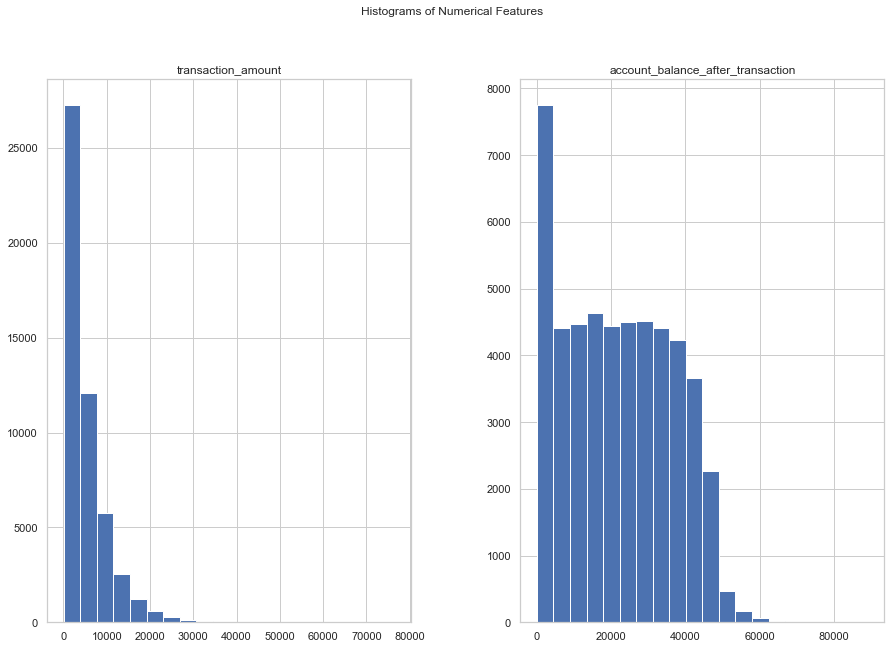

In [61]:
# Histograms for numerical features
df_transaction[transaction_num_fea].hist(bins=20, figsize=(15,10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

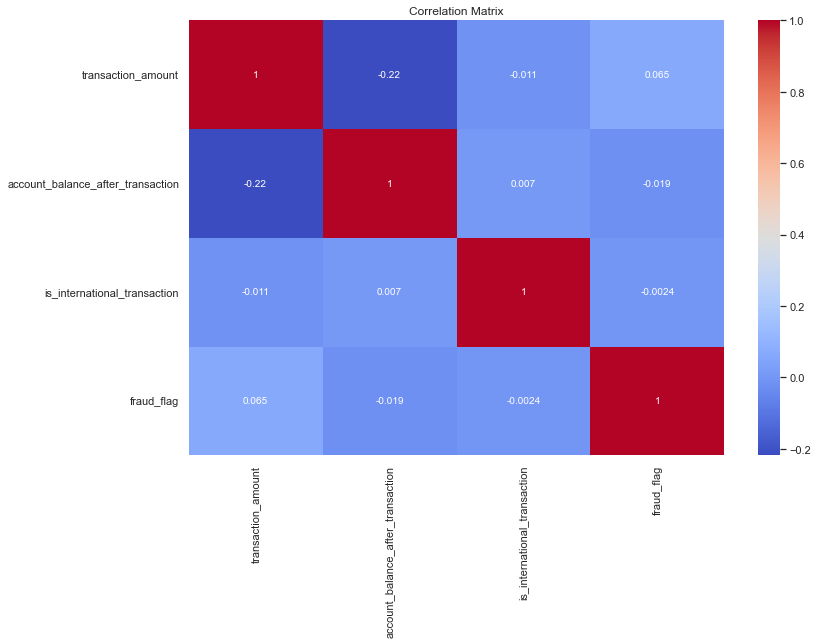

In [62]:
# Correlation matrix

corr = df_transaction.select_dtypes(include='number').corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [63]:
# Fraud rate
fraud_rate = df_transaction['fraud_flag'].value_counts(normalize=True) * 100
print(fraud_rate.round(2).astype(str) + '%')

0    99.0%
1     1.0%
Name: fraud_flag, dtype: object


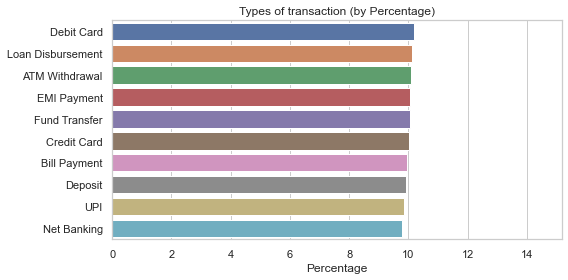

In [64]:
# Calculate percentage per transaction type
fraud_type_pct = (
    df_transaction['transaction_type'].value_counts(normalize=True) * 100
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=fraud_type_pct.values, y=fraud_type_pct.index)
plt.xlabel("Percentage")
plt.title("Types of transaction (by Percentage)")
plt.xlim(0, fraud_type_pct.max() + 5)  # Add space to the right
plt.tight_layout()
plt.show()

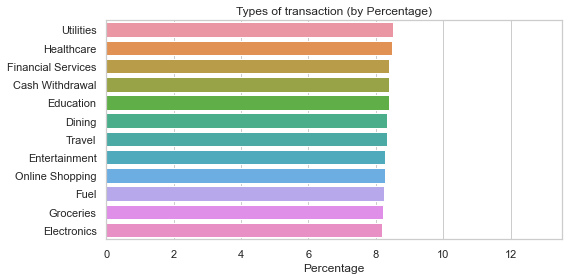

In [65]:
# Calculate percentage per merchant category
fraud_type_pct = (
    df_transaction['merchant_category'].value_counts(normalize=True) * 100
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=fraud_type_pct.values, y=fraud_type_pct.index)
plt.xlabel("Percentage")
plt.title("Types of transaction (by Percentage)")
plt.xlim(0, fraud_type_pct.max() + 5)  # Add space to the right
plt.tight_layout()
plt.show()

In [66]:
# Your target
target = 'fraud_flag'

# Select categorical features (excluding target)
transaction_cat_cols = transaction_cat_fea
if target in transaction_cat_cols :
    transaction_cat_cols.remove(target)

# Select numerical features (excluding target)
transaction_num_cols = transaction_num_fea
if target in transaction_num_cols : 
    transaction_num_cols.remove(target)

In [67]:
dfs = []  # To store results for all columns

for col in transaction_cat_cols:
    # Create a crosstab: counts of each category by fraud_flag
    ct = pd.crosstab(df_transaction[col], df_transaction[target], dropna=False)
    
    # Rename target columns
    ct = ct.rename(columns={0: 'not_fraud', 1: 'fraud'})
    
    # Optional: add totals
    ct['Total'] = ct.sum(axis=1)
    
    # Calculate percentages per row
    ct_pct = ct.div(ct['Total'], axis=0) * 100
    ct_pct = ct_pct.round(2)
    
    # Combine counts and percentages in one DataFrame
    combined = ct.astype(str) + " (" + ct_pct.astype(str) + "%)"
    
    # Add a column name to identify which feature this is from
    combined.insert(0, col, combined.index)    
    combined.columns.name = None
    
    dfs.append(combined.reset_index(drop=True))

In [68]:
df_tsct_tsct_type = dfs[0]
df_tsct_tsct_type

,transaction_type,not_fraud,fraud,Total
0,ATM Withdrawal,4994 (99.05%),48 (0.95%),5042 (100.0%)
1,Bill Payment,4929 (99.08%),46 (0.92%),4975 (100.0%)
2,Credit Card,4959 (99.04%),48 (0.96%),5007 (100.0%)
3,Debit Card,5043 (99.12%),45 (0.88%),5088 (100.0%)
4,Deposit,4917 (99.01%),49 (0.99%),4966 (100.0%)
5,EMI Payment,4975 (98.89%),56 (1.11%),5031 (100.0%)
6,Fund Transfer,4976 (99.02%),49 (0.98%),5025 (100.0%)
7,Loan Disbursement,5005 (98.99%),51 (1.01%),5056 (100.0%)
8,Net Banking,4841 (98.98%),50 (1.02%),4891 (100.0%)
9,UPI,4859 (98.78%),60 (1.22%),4919 (100.0%)


In [69]:
df_tsct_merchant_type = dfs[1]
df_tsct_merchant_type

,merchant_category,not_fraud,fraud,Total
0,Cash Withdrawal,4151 (98.88%),47 (1.12%),4198 (100.0%)
1,Dining,4107 (98.56%),60 (1.44%),4167 (100.0%)
2,Education,4149 (99.02%),41 (0.98%),4190 (100.0%)
3,Electronics,4055 (99.12%),36 (0.88%),4091 (100.0%)
4,Entertainment,4097 (99.06%),39 (0.94%),4136 (100.0%)
5,Financial Services,4163 (99.14%),36 (0.86%),4199 (100.0%)
6,Fuel,4074 (98.91%),45 (1.09%),4119 (100.0%)
7,Groceries,4080 (99.25%),31 (0.75%),4111 (100.0%)
8,Healthcare,4194 (99.01%),42 (0.99%),4236 (100.0%)
9,Online Shopping,4082 (98.79%),50 (1.21%),4132 (100.0%)


In [70]:
df_tsct_device = dfs[2]
df_tsct_device

,device_used,not_fraud,fraud,Total
0,ATM,12572 (99.03%),123 (0.97%),12695 (100.0%)
1,Mobile,12429 (99.0%),126 (1.0%),12555 (100.0%)
2,POS,12083 (98.94%),129 (1.06%),12212 (100.0%)
3,Web,12414 (99.01%),124 (0.99%),12538 (100.0%)


In [71]:
df_tsct_tsct_status = dfs[3]
df_tsct_tsct_status

,transaction_status,not_fraud,fraud,Total
0,Failed,0 (0.0%),255 (100.0%),255 (100.0%)
1,Success,49498 (99.5%),247 (0.5%),49745 (100.0%)


In [72]:
df_tsct_tsct_notes = dfs[4]
df_tsct_tsct_notes

,transaction_notes,not_fraud,fraud,Total
0,Payment for Cash Withdrawal,4151 (98.88%),47 (1.12%),4198 (100.0%)
1,Payment for Dining,4107 (98.56%),60 (1.44%),4167 (100.0%)
2,Payment for Education,4149 (99.02%),41 (0.98%),4190 (100.0%)
3,Payment for Electronics,4055 (99.12%),36 (0.88%),4091 (100.0%)
4,Payment for Entertainment,4097 (99.06%),39 (0.94%),4136 (100.0%)
5,Payment for Financial Services,4163 (99.14%),36 (0.86%),4199 (100.0%)
6,Payment for Fuel,4074 (98.91%),45 (1.09%),4119 (100.0%)
7,Payment for Groceries,4080 (99.25%),31 (0.75%),4111 (100.0%)
8,Payment for Healthcare,4194 (99.01%),42 (0.99%),4236 (100.0%)
9,Payment for Online Shopping,4082 (98.79%),50 (1.21%),4132 (100.0%)


In [73]:
df_tsct_inter = dfs[5]
df_tsct_inter

,is_international_transaction,not_fraud,fraud,Total
0,0,48980 (98.99%),498 (1.01%),49478 (100.0%)
1,1,518 (99.23%),4 (0.77%),522 (100.0%)


In [74]:
del dfs

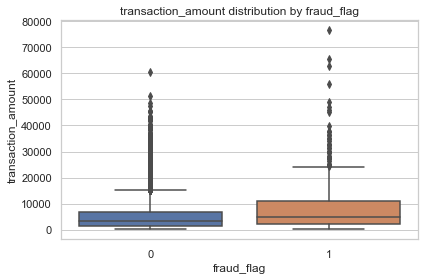

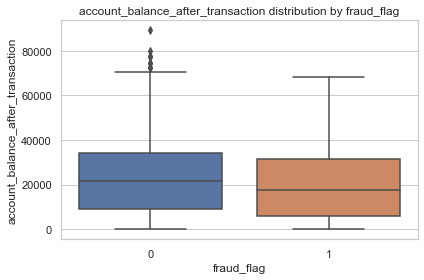

In [75]:
# Plot numerical features vs fraud_flag (boxplots)
for col in transaction_num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_transaction, x=target, y=col)
    plt.title(f"{col} distribution by {target}")
    plt.tight_layout()
    plt.show()

In [76]:
import os

# Folder path
folder_path = '../Data/Transaction_stats'
# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

In [77]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_tsct_type.csv')

# Save DataFrame to CSV without index
df_tsct_tsct_type.to_csv(file_path, index=False)

In [78]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_merchant_type.csv')

# Save DataFrame to CSV without index
df_tsct_merchant_type.to_csv(file_path, index=False)

In [79]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_device.csv')

# Save DataFrame to CSV without index
df_tsct_device.to_csv(file_path, index=False)

In [80]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_tsct_status.csv')

# Save DataFrame to CSV without index
df_tsct_tsct_status.to_csv(file_path, index=False)

In [81]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_tsct_notes.csv')

# Save DataFrame to CSV without index
df_tsct_tsct_notes.to_csv(file_path, index=False)

In [82]:
# File path using the variable name
file_path = os.path.join(folder_path, 'tsct_inter.csv')

# Save DataFrame to CSV without index
df_tsct_inter.to_csv(file_path, index=False)